Clone the repo.
And Install libs

In [ ]:
!pip install pytorch-lightning
!pip install --upgrade wandb

!git clone https://github.com/mythrex/deep_dream_textual_data.git
%cd deep_dream_textual_data
!mkdir .vector_cache
!wget https://storage.googleapis.com/ml_shared_bucket/kraken/glove.6B.zip -P ./.vector_cache

Only if you want to train the model. 

Skip this part!
Uncomment this part!

Prepare the data

In [2]:
!mkdir ./outputs/fc2
!mkdir ./outputs/contrast

import torch

#handling text data
from torchtext import data
import random

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SEED = 2020

#Torch
torch.manual_seed(SEED)

#Cuda algorithms
torch.backends.cudnn.deterministic = True

#define hyperparameters
args = {'data_path': './data/IMDB Dataset.csv', 
        'embedding_dim': 100, 
        'dropout': 0.5,
        'lr': 5e-4,
        'batch_size': 256, 
        'epochs': 50, 
        'gpus': 0, 
        'progress_bar_refresh_rate': 25, 
        'wandb_log_step': 10, 
        'wandb_run_name': 'run_1', 
        'wandb_project_name': 'deep_dream', 
        'model_ckpt_path': './ckpts/model.ckpt'}


mkdir: cannot create directory ‘./outputs/fc2’: File exists
mkdir: cannot create directory ‘./outputs/contrast’: File exists


In [3]:
TEXT = data.Field(
    tokenize='spacy', batch_first=True, include_lengths=True)

LABEL = data.Field(batch_first=True, sequential=False)

fields = [('text', TEXT), ('label', LABEL)]

print(f"Loading file: {args['data_path']}")
training_data = data.TabularDataset(
    path=args['data_path'], format='csv', fields=fields, skip_header=True)

#print preprocessed text
# print(vars(training_data.examples[0]))

print("Splitting the data!")
train_data, valid_data = training_data.split(split_ratio=0.7, random_state = random.seed(SEED))

print("Building Vocab!")
TEXT.build_vocab(train_data, min_freq=3, vectors = "glove.6B.100d")
LABEL.build_vocab(train_data)

# #Load an iterator
train_iterator, valid_iterator = data.BucketIterator.splits(
    (train_data, valid_data), 
    batch_size = args['batch_size'],
    sort_key = lambda x: len(x.text),
    sort_within_batch=True,
    device = device)

Loading file: ./data/IMDB Dataset.csv
Splitting the data!
Building Vocab!
100%|█████████▉| 399056/400000 [00:30<00:00, 25514.40it/s]

# Get model from checkpoint

Let's save us time and download the model checkpoint.

Model architecture.

<img src="readme_data/model.png" height="400">

In [7]:
from model import TextClassifier

model = TextClassifier(args, 
                        TEXT=TEXT, 
                        LABEL=LABEL, 
                        train_iterator=train_iterator,
                        valid_iterator=valid_iterator)

model = model.load_from_checkpoint('./ckpts/model.ckpt', 
                                   TEXT=TEXT, 
                                   LABEL=LABEL, 
                                   train_iterator=train_iterator, 
                                   valid_iterator=valid_iterator)

> If above cell caused an error, you may have to train your network again. Run the following cell and then rerun the above cell

In [ ]:
%%shell
# python trainer.py --data_path="./data/IMDB Dataset.csv" \
#                    --gpus=0 \
#                    --wandb_run_name='run_1' \
#                    --wandb_project_name='deep_dream' \
#                    --model_ckpt_path='./ckpts/model.ckpt'

# Experiments

In [8]:
from tqdm.notebook import tqdm
from PIL import Image
from matplotlib import style
from utils import *
style.use('seaborn-dark')

orig_embeddings = TEXT.vocab.vectors.numpy()

### EXP#1 Do this for Multiple sentences
1. Find the nearby words.
2. Plot the embeddings of words using TSNE.
3. Save the word Embeddings

Model predicted: negative
Dreaming!!
Model predicted: positive
Dreaming!!



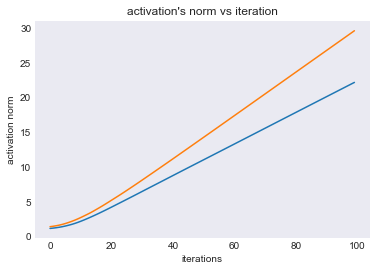

In [9]:
# One positive and one negative is important. for no errors.
sentences = ['I hate this.', 
             "I love this show."]

LR = 0.005
ITER = 100
K=20

pos_neg_words = {'positive': set(), 'negative': set()}
sentences_embedding_steps = []

for n, sentence in tqdm(enumerate(sentences), total=len(sentences)):
    model.eval()
    tensor = sentence_to_tensor(sentence, TEXT)
    out, embeddings, hidden = model(tensor)
    prediction = LABEL.vocab.itos[out.argmax(-1).item()]
    print(f"Model predicted: {prediction}")

    print("Dreaming!!")

    # TextClassifier.load_from_checkpoint('./ckpts/model.ckpt', **params)
    embeddings_steps = dream(tensor, model, ITER, LR)
    sentences_embedding_steps.append(embeddings_steps)
    # save initial word_cloud
    make_word_cloud(embeddings_steps, 
                    step=0, 
                    prediction=prediction, 
                    pos_neg_words=pos_neg_words,
                    orig_embeddings=orig_embeddings,
                    k=K,
                    text=TEXT,
                    filename=f"./outputs/fc2/initial_{n}.png")
    # save final word_cloud
    make_word_cloud(embeddings_steps, 
                    step=-1, 
                    prediction=prediction, 
                    pos_neg_words=pos_neg_words,
                    text=TEXT,
                    orig_embeddings=orig_embeddings,
                    filename=f"./outputs/fc2/{n}.png")

sentences_embedding_steps = np.asarray(sentences_embedding_steps)

As you can see, y-axis contains the norm / magnitude of hidden layer vectors.

As we iterate over and over again, the magnitude of hidden vector increases, the result of this will be the input embedding will now reflect the contents of hidden state vector.

#### Some experiments that we can try are

1. Find the words that are similar to initial sentence embeddings.
2. Find the words that are similar to final sentence embeddings after dreaming.
3. Visualize how embeddings have changed over iterations.

Model predicted `first sentence` as `negative` and `second` as `positive`.

Let's now see what are the words similar initial embedding vs the words similar to final embeddings.

Sentence 1

> I hate this.

_Note: Functions called above are automatically saving wordclouds_

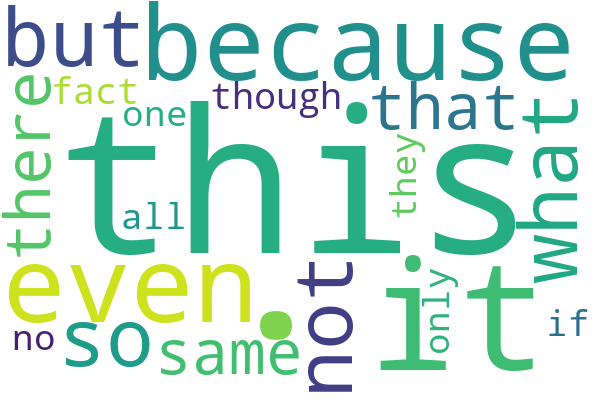

In [6]:
# words similar to initial embeddings (Before Dreaming)
Image.open("outputs/fc2/initial_0.png")

Image contains words scaled to similarity. Most similar, the biggest

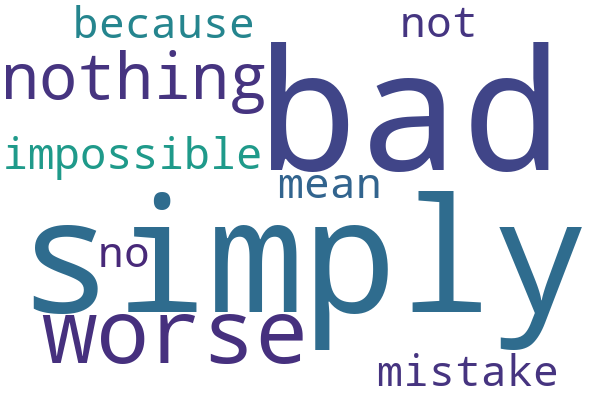

In [7]:
# words similar to final embeddings after dreaming.
Image.open("outputs/fc2/0.png")

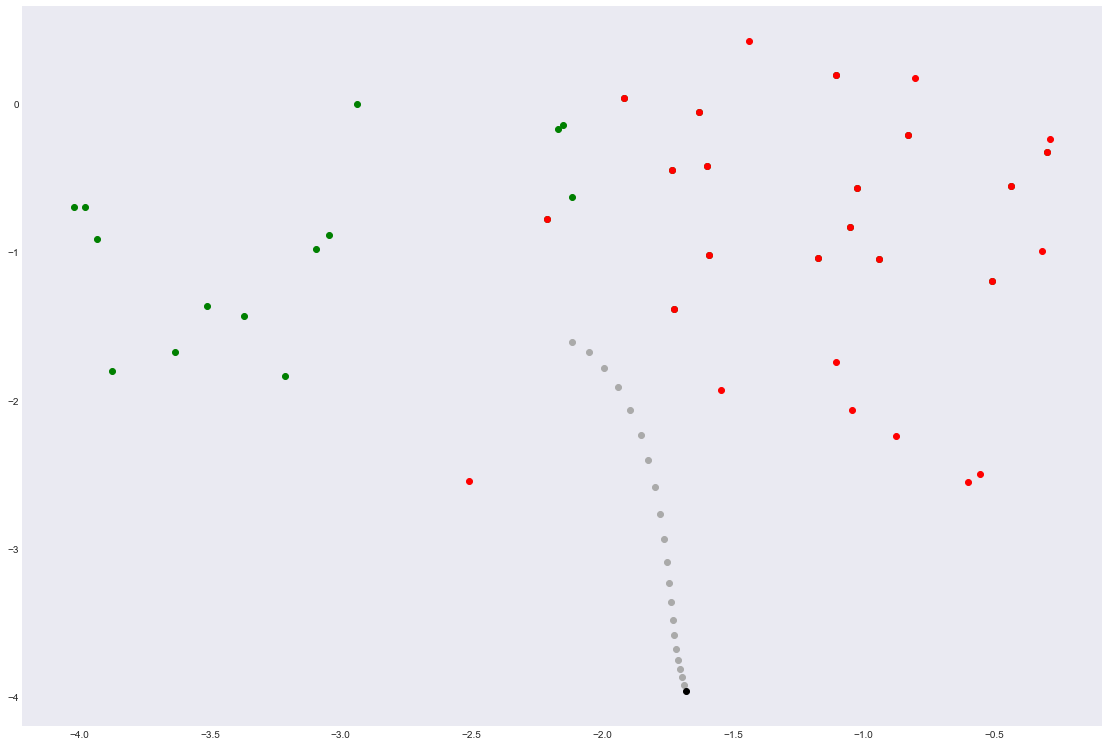

In [8]:
embedding_arr_reduced, colors = visualize_embeddings(pos_neg_words, 
                                                     sentences_embedding_steps, 
                                                     text=TEXT,
                                                    #  sentence no, here we are choosing sentence idx 1, you can try with 0
                                                     step=0, 
                                                     debug=True,
                                                     tsne_config={'perplexity': 50, 'learning_rate': 10, 'n_iter': 500}
                                                     )

The graph clearly shows that embeddings got away from positive words, and got near negative words.

> Red dots: negative words like "bad, impossible, mistake"

> Green dots: positive words like "unique, celebrated"

> Gray dots: intermediate embeddings of sentence (during dreaming) 

> Black dot: final embedding of sentence (after dreaming)

Let's analyse for sentence 2

> I love this show.

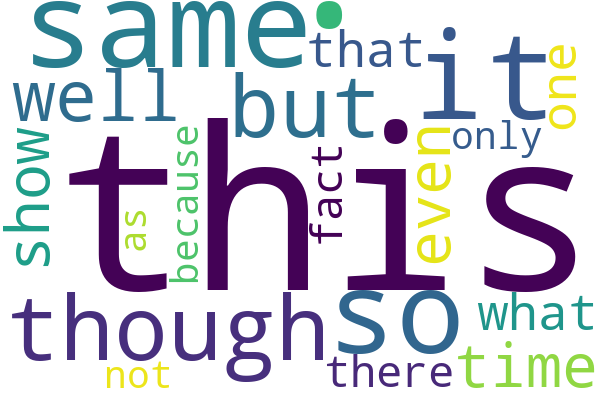

In [9]:
# words similar to initial embeddings
Image.open("./outputs/fc2/initial_1.png")

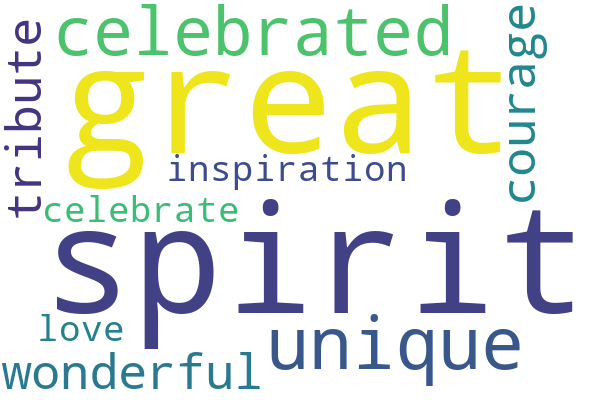

In [10]:
# words similar to final embeddings after dreaming.
Image.open("./outputs/fc2/1.png")

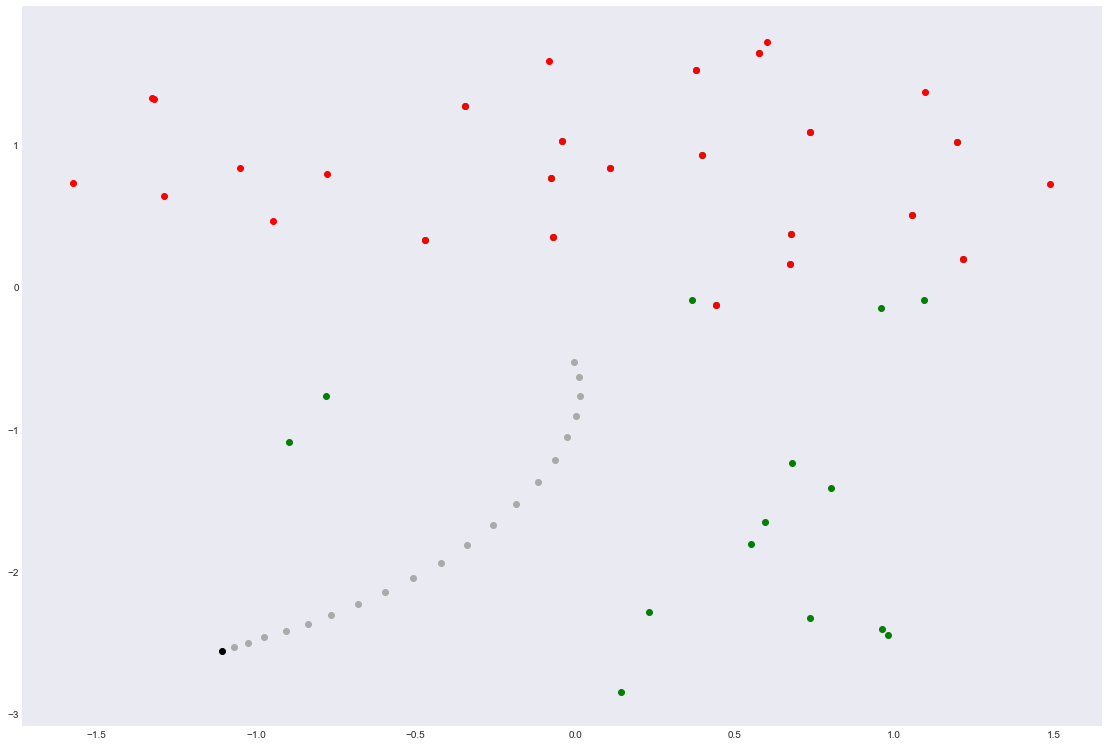

In [11]:
embedding_arr_reduced, colors = visualize_embeddings(pos_neg_words, 
                                                     sentences_embedding_steps, 
                                                     text=TEXT,
                                                    #  sentence no, here we are choosing sentence idx 1, you can try with 0
                                                     step=1, 
                                                     debug=True,
                                                     tsne_config={'perplexity': 50, 'learning_rate': 10, 'n_iter': 500}
                                                     )

Here dreaming, made sentence embeddings towards positive words.

<iframe src="https://player.vimeo.com/video/449574992" width="300" height="200" frameborder="1" allow="autoplay; fullscreen" allowfullscreen></iframe>

Observe how sentence embedding start from step_1 and move to step_21. The sentence embedding started in between positive and negative words and as algorithm dreams, the embedding move towards positive words.

You can try few more things on hosted embeddings on [TensorFlow projector here](https://projector.tensorflow.org/?config=https://gist.githubusercontent.com/mythrex/02f9d3b8575910943b89d9964e7fde56/raw/266f8d01fd72737c7ee53072f8e91b2f2bb7e027/Deep%2520dream%2520text%2520embeddings).

#### Conclusions
The word embeddings after dreaming becomes similar to the words in `model prediction`, though if we look at similar words of initial embeddings, they were more or less same for the two sentences even when they were conveying very different meanings.

For e.g.
- `negative` prediction becomes near to words like _mistake, dirty, bad_
- `positive` prediction becomes near to words like _unique, great, celebrated_

Let's now visualize how embeddings of sentence have changed over time.

#### This shows that hidden representations in neural networks, captures and understand the essence of the sentences.

### EXP#2 Try with contrasting sentences.

Sentence which convey different in first half, but second half of the sentences convey different meaning.

<img src="https://i.kym-cdn.com/entries/icons/facebook/000/028/720/t3qkhrohrh321.jpg" height="200" alt="first_half" />

Model predicted: positive
Dreaming!!
Model predicted: negative
Dreaming!!



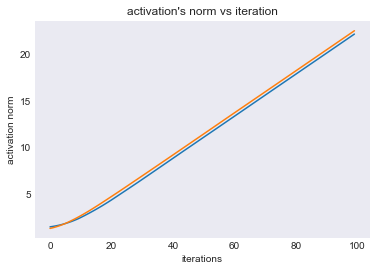

In [12]:
sentences = ['The show was very long and boring but the direction was really amazing.',
             'I hated the show because of nudity but the acting was really classy.']

LR = 0.005
ITER = 100
K=20

pos_neg_words = {'positive': set(), 'negative': set()}
sentences_embedding_steps = []

for n, sentence in tqdm(enumerate(sentences), total=len(sentences)):
    model.eval()
    tensor = sentence_to_tensor(sentence, TEXT)
    out, embeddings, hidden = model(tensor)
    prediction = LABEL.vocab.itos[out.argmax(-1).item()]
    print(f"Model predicted: {prediction}")

    print("Dreaming!!")

    # TextClassifier.load_from_checkpoint('./ckpts/model.ckpt', **params)
    embeddings_steps = dream(tensor, model, ITER, LR)
    sentences_embedding_steps.append(embeddings_steps)
    # save initial word_cloud
    make_word_cloud(embeddings_steps, 
                    step=0, 
                    prediction=prediction, 
                    pos_neg_words=pos_neg_words,
                    orig_embeddings=orig_embeddings,
                    k=K,
                    text=TEXT,
                    filename=f"./outputs/contrast/initial_{n}.png")
    # save final word_cloud
    make_word_cloud(embeddings_steps, 
                    step=-1, 
                    prediction=prediction, 
                    pos_neg_words=pos_neg_words,
                    text=TEXT,
                    orig_embeddings=orig_embeddings,
                    filename=f"./outputs/contrast/{n}.png")

sentences_embedding_steps = np.asarray(sentences_embedding_steps)

Few things to note here:

1. `The show was very long and boring but the direction was really amazing.` is classified as `positive`. This sentence is actually difficult to classify for a human too.
2. `I hated the show because of nudity but the acting was really classy.` is classified as `negative`.
3. Unlike the first case. Activations for these sentence are more or less similar, this means there is no classifying power of model for these sentences.

Let's look at the nearby words of these sentences before and after dreaming.

For sentence 1

`The show was very long and boring but the direction was really amazing.`

Similar words of sentence 1(Before Dreaming) 

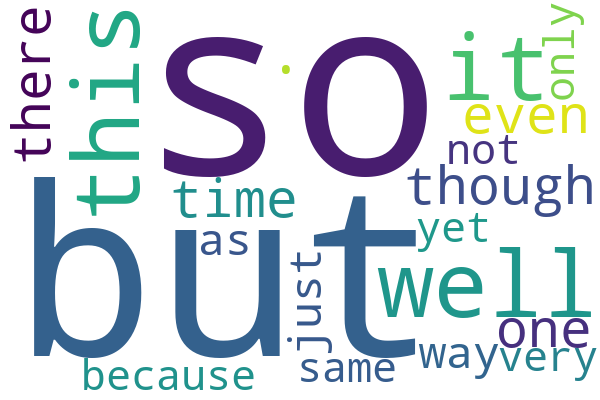

In [13]:
Image.open("outputs/contrast/initial_0.png")

Similar words of sentence 1(After Dreaming) 

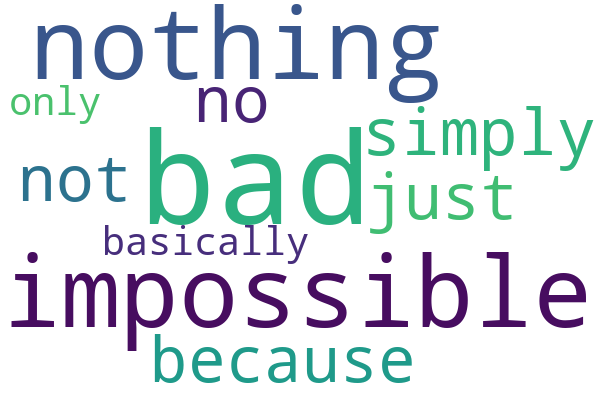

In [14]:
Image.open("outputs/contrast/0.png")

Similar words of sentence 2(Before Dreaming) 

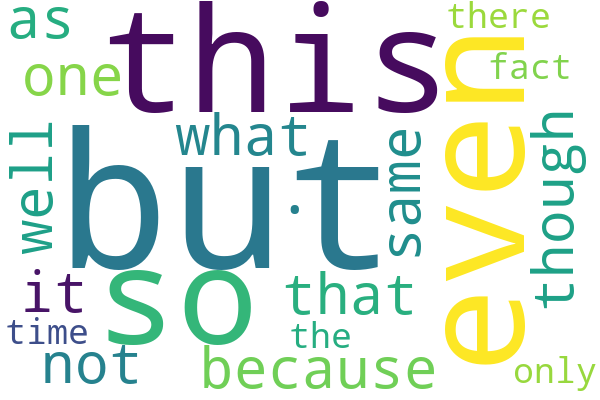

In [15]:
Image.open("outputs/contrast/initial_1.png")

Similar words of sentence 2(After Dreaming) 

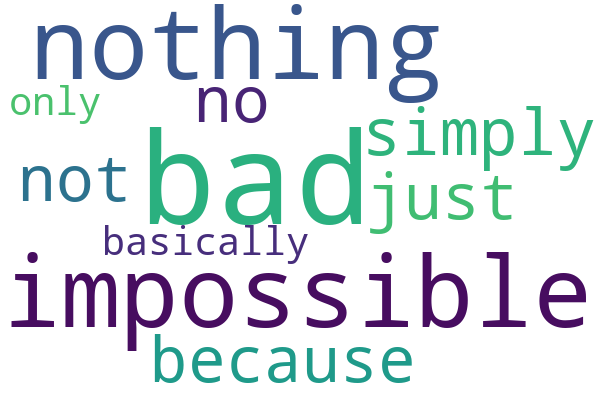

In [16]:
Image.open("outputs/contrast/0.png")

#### Conclusion

Looking at similar words after dreaming for *both the sentences*, the similar words are *more or less same* even though both of these sentences are predicted oppositely. This can be attributed to model's layer's incapability of distinguishing such sentences.

Experiments like these help us understand these black boxes better.

My name is [Shivam Kaushik](https://mythrex.github.io) you can find me on:

<a href="https://github.com/mythrex">
  <img target="_vblank" align="left" alt="Shivam Kaushik | Github" width="21px" style="margin-right: 10px;" src="https://github.githubassets.com/images/modules/logos_page/GitHub-Mark.png" />
</a>
<a href="https://www.linkedin.com/in/shivamkaushik73/">
  <img target="_vblank" align="left" alt="Shivam Kaushik | LinkedIn" width="21px" style="margin-right: 10px;" src="https://image.flaticon.com/icons/svg/174/174857.svg" />
</a>